In [57]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import re


PREFIX='a video of '
events = [
    "Riding",
    "Fighting",
    "Playing",
    "Running",
    "Lying",
    "Chasing",
    "Jumping",
    "Falling",
    "Guiding",
    "Stealing",
    "Littering",
    "Tripping",
    "Pickpockering",
]
description = [
    "a person riding a bicycle on the street",  # Added context
    "multiple people engaged in a physical fight",  # More specific than "fighting"
    "a group of people playing a sport together",  # Added "sport" for visual clarity
    "a person running",  # Added context
    "a person lying motionless on the ground",  # "Motionless" helps distinguish from falling
    "a person aggressively chasing another person",  # "Aggressively" adds distinction
    "a person jumping high in the air with both feet",  # More specific than just "jumping"
    "a person accidentally falling to the ground",  # "Accidentally" helps distinguish
    "a person gently guiding another person by the arm",  # Added detail
    "a person stealing other person",  # More specific than "stealing"
    "a person deliberately throwing garbage on the ground",  # "Deliberately" adds clarity
    "a person tripping over an obstacle",  # More descriptive
    "a person pickpocketing a wallet from someone's pocket",  # Very specific
]
normal_prompt = "a normal view (persons walking or standing)"
description.append(normal_prompt)
description=[PREFIX +desc for desc in description]
events_description = {event: desc for event, desc in zip(events, description)}

In [58]:
incorrects = []
total = 0
total_evaluated=0
def define_selected_event(predicted_event, probability, prompt, normal_class, event):
    global total_evaluated, total  # Declare 'total' as global to modify the global variable
    total+=1
    if predicted_event == normal_class and prompt == "" and probability == 0.0:
        return normal_class
    else:
        #predicted_event.pop()
        #probability = np.delete(probability, -1)
        exp_probs = np.exp(probability - np.max(probability))  # Subtract max for numerical stability
        softmax_probs = exp_probs / np.sum(exp_probs)
        # Find the index of the maximum probability
        max_index = np.argmax(softmax_probs)
        # Get the corresponding event
        selected_event = predicted_event[max_index]
        # If the selected event is not a normal view, return it
        if selected_event != event:
            incorrects.append([ event, predicted_event, softmax_probs])
        total_evaluated += 1  # Increment the global 'total' variable
        return selected_event
def check_precision(frames_number, video_name, predicted_events, event, anomaly_classes, prompts, mode,probabilities):
    # TN Prediction and Reality are true
    # TN Prediction and Reality are false
    # FN Prediction is false and Reality is true
    # FP Prediction is true and Reality is false
    normal_class = PREFIX + "a normal view (persons walking or standing)"
    #
    all_classes = anomaly_classes
    frames = np.load("/home/ubuntu/Database/ALL/GT/gt_ALL.npz")
    frames= frames[video_name]
    frames = np.append(frames, frames[-1])
    # Create a dictionary to convert class names to numeric indices
    class_to_idx = {cls: idx for idx, cls in enumerate(all_classes)}
    # Example: {"a normal view...": 0, "a person riding...": 1, ...}
    num_classes = len(all_classes)  # 14
    cm = np.zeros((num_classes, num_classes), dtype=int)
    prompts = [prompt.lower().split('.')[0] for prompt in prompts]
    # Save frames_number, predicted_events, and prompts into a numpy array
    fn_stored=0
    tn_stored=0
    for i in range(len(predicted_events)):
        # Get ground truth
        is_anomaly = frames[frames_number[i] - 1]  # 0 or 1
        # Determine true class using EVENT when anomaly exists
        true_class = event if is_anomaly == 1 else normal_class
        pred_class = define_selected_event(predicted_events[i], probabilities[i], prompts[i], normal_class, event)
        if true_class in predicted_events[i]:
            pred_class = true_class
        if (mode==0 or mode==2):
            pass
        elif prompts[i] == "yes":
            pass
        elif prompts[i] == "no":
            continue
        else:
            if true_class == pred_class:
                pass
            else:
                continue
        # Get predicted class
        
        # Convert to indices (skip if class not recognized)
        true_idx = class_to_idx.get(true_class, -1)
        pred_idx = class_to_idx.get(pred_class, -1)
        
        if true_idx != -1 and pred_idx != -1:
            cm[true_idx, pred_idx] += 1
    # Get the index of your event class
    event_idx = class_to_idx[event]
    

    # Calculate metrics ONLY for your event class
    tp = cm[event_idx, event_idx]  # TNs for event
    fp = np.sum(cm[:, event_idx]) - tp  # FPs (other classes predicted as event)
    fn =  np.sum(cm[event_idx, :]) - tp  # FNs (event misclassified as others)
    tn = np.sum(cm) - tp - fp - fn  # TNs
    fn += fn_stored
    tn += tn_stored
    return tp, fp, fn, tn, cm
rute_stored='/home/ubuntu/Tesis/Storage/XCLIP'
files=os.listdir(rute_stored)
files = [f for f in files if f.endswith('.npy')]
all_prompts = []
all_description = []
df= pd.DataFrame(columns=['Name', 'Event', 'Mode', 'TP', 'FP', 'FN', 'TN'])
prompts_number=0
class_to_idx = {cls: idx for idx, cls in enumerate(description)}
# Example: {"a normal view...": 0, "a person riding...": 1, ...}
num_classes = len(description)  # 14
cm_sum = np.zeros((num_classes, num_classes), dtype=int)
count=0
df= pd.DataFrame(columns=['Name', 'Event', 'Mode', 'TP', 'FP', 'FN', 'TN'])
for file in files:
    #print(file)
    name= file.split('_CLIP_')[0]
    mode=int(file.split('_CLIP_')[1][0])
    event=file.split('_CLIP_')[1][2:].split('.')[0]
    info_stored=np.load(f"{rute_stored}/{file}", allow_pickle=True)
    frames_number=info_stored[0]
    predicted_events=info_stored[1]
    prompts=info_stored[2]
    probabilities=info_stored[3]
    print(prompts)
    tp, fp, fn, tn, cm=check_precision(frames_number, name, predicted_events, event,description, prompts, mode,probabilities)
    cm_sum += cm
    row = {
    'Name':name, 'Event':event, 'Mode':mode, 'TP':tp, 'FP':fp, 'FN':fn, 'TN':tn
    }
    df =pd.concat([df, pd.DataFrame([row])], ignore_index=True) 
print(df)

['' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' ''
 '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' ''
 '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' ''
 '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' ''
 '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '']
['' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' ''
 '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' ''
 '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' ''
 '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' ''
 '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' ''
 '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' ''
 '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' ''
 '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' ''
 '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '

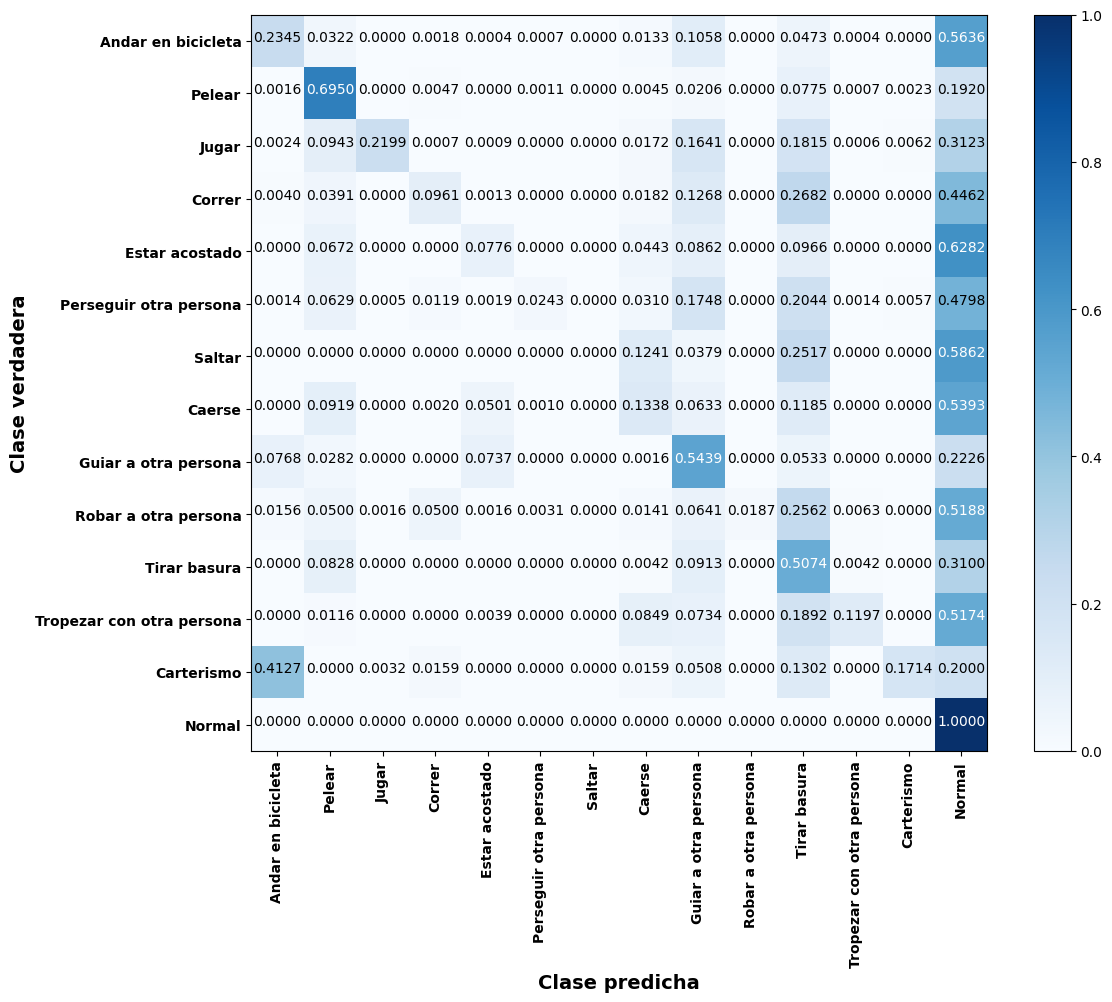

In [59]:
plt.figure(figsize=(12, 10))
cm_sum = cm_sum / cm_sum.sum(axis=1, keepdims=True)
plt.imshow(cm_sum, interpolation='nearest', cmap=plt.cm.Blues)
#plt.title(f"Matriz de confusión: {mode_names[mode]}", fontsize=16, fontweight='bold')
plt.xlabel("Clase predicha", fontsize=14, fontweight='bold')
plt.ylabel("Clase verdadera", fontsize=14, fontweight='bold')
plt.colorbar()
# Replace class names with the ones from the replace list
replace = [
    "Andar en bicicleta",
    "Pelear",
    "Jugar",
    "Correr",
    'Estar acostado',
    "Perseguir otra persona",
    "Saltar",
    "Caerse",
    "Guiar a otra persona",
    "Robar a otra persona",
    "Tirar basura",
    "Tropezar con otra persona",
    "Carterismo",
    'Normal',
]
updated_classes = replace
tick_marks = np.arange(num_classes)   
plt.xticks(tick_marks, updated_classes, rotation=90, fontweight='bold')  # Rotate x-axis labels for better visibility
plt.yticks(tick_marks, updated_classes, fontweight='bold')   # Annotate the matrix with the values
thresh = cm_sum.max() / 2.0
for i, j in np.ndindex(cm_sum.shape):
    plt.text(j, i, f"{cm_sum[i, j]:.4f}",
                        horizontalalignment="center",
                        color="white" if cm_sum[i, j] > thresh else "black")   
plt.tight_layout()
#plt.savefig(f"CM/confusion_matrix_{mode_names[mode]}.png", bbox_inches='tight')
plt.show()

In [60]:
df_respaldo=df.copy()
#df_respaldo=df_respaldo.loc[~df_respaldo["Name"].str.endswith("_1")] 
print(df_respaldo)
df_sum = df_respaldo.groupby(["Event", "Mode"])[
    ["TP", "FP", "FN", "TN"]
].sum().reset_index()

# Initialize precision, recall, accuracy with zeros
df_sum["Precision"] = 0.0
df_sum["Recall"] = 0.0
df_sum["Accuracy"] = 0.0

# Calculate only where the denominator is not zero
mask_prec = (df_sum["TP"] + df_sum["FP"]) != 0
df_sum.loc[mask_prec, "Precision"] = (
    df_sum.loc[mask_prec, "TP"] / (df_sum.loc[mask_prec, "TP"] + df_sum.loc[mask_prec, "FP"])
)

mask_recall = (df_sum["TP"] + df_sum["FN"]) != 0
df_sum.loc[mask_recall, "Recall"] = (
    df_sum.loc[mask_recall, "TP"] / (df_sum.loc[mask_recall, "TP"] + df_sum.loc[mask_recall, "FN"])
)

mask_acc = (df_sum["TP"] + df_sum["FP"] + df_sum["FN"] + df_sum["TN"]) != 0
df_sum.loc[mask_acc, "Accuracy"] = (
    (df_sum.loc[mask_acc, "TP"] + df_sum.loc[mask_acc, "TN"]) /
    (df_sum.loc[mask_acc, "TP"] + df_sum.loc[mask_acc, "FP"] + df_sum.loc[mask_acc, "FN"] + df_sum.loc[mask_acc, "TN"])
)
df_sum.drop(columns=['TP', 'FP', 'FN', 'TN'], inplace=True)
df_sum['F1'] = 2 * df_sum['Precision'].astype(float) * df_sum['Recall'].astype(float) / (df_sum['Precision'].astype(float) + df_sum['Recall'].astype(float))
df_sum['F1'].fillna(0, inplace=True)  # Handle division by zero
df_sum.drop(columns=['Event'], inplace=True)
df_sum=df_sum.groupby(["Mode"]).mean()
mode_names = {
        0: "CLIP y Reglas",
        1: "CLIP y Reglas con MLLM",
        2: "CLIP y Reglas Una clase",
    }
df_sum.rename(index=mode_names, inplace=True)
print(df_sum)

        Name                                              Event Mode  TP FP  \
0    4_110_1                        a video of a person running    0  17  0   
1    2_083_1  a video of a person aggressively chasing anoth...    0   3  0   
2         20  a video of a person deliberately throwing garb...    0  26  0   
3    3_095_1  a video of a person deliberately throwing garb...    0  19  0   
4    4_107_1  a video of a person aggressively chasing anoth...    0   0  0   
..       ...                                                ...  ...  .. ..   
247  4_109_1  a video of a group of people playing a sport t...    0   4  0   
248  4_105_1  a video of multiple people engaged in a physic...    0  37  0   
249  4_082_1  a video of multiple people engaged in a physic...    0  81  0   
250   000259                        a video of a person running    0   2  0   
251  1_088_1  a video of multiple people engaged in a physic...    0  88  0   

      FN   TN  
0     18   78  
1    234  327  
2  

/tmp/ipykernel_10548/2034563803.py:15: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_sum.loc[mask_prec, "Precision"] = (
/tmp/ipykernel_10548/2034563803.py:20: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.21986970684039087 0.1338100102145046 0.02429728442115293
 0.5074309978768577 0.5438871473354232 0.0 0.07758620689655173
 0.17142857142857143 0.23446745562130178 0.09608540925266904 0.01875
 0.11969111969111969 0.695003391363328]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_sum.loc[mask_recall, "Recall"] = (
/tmp/ipykernel_10548/2034563803.py:25: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise 

In [61]:
def calculate_ap(precision, recall):
    # Sort by recall (ascending)
    sorted_indices = np.argsort(recall)
    precision = np.array(precision)[sorted_indices]
    recall = np.array(recall)[sorted_indices]

    # Pad with (0,0) and (1,0)
    precision = np.concatenate(([0], precision, [0]))
    recall = np.concatenate(([0], recall, [1]))

    # Compute AP as the area under the raw curve (no interpolation)
    ap = 0.0
    for i in range(1, len(recall)):
        delta_recall = recall[i] - recall[i - 1]
        ap += delta_recall * precision[i]

    return ap
df_check = df_respaldo.copy()

# Initialize precision, recall, accuracy with zeros
df_check["Precision"] = 0.0
df_check["Recall"] = 0.0
df_check["Accuracy"] = 0.0

# Calculate only where the denominator is not zero
mask_prec = (df_check["TP"] + df_check["FP"]) != 0
df_check.loc[mask_prec, "Precision"] = (
    df_check.loc[mask_prec, "TP"] / (df_check.loc[mask_prec, "TP"] + df_check.loc[mask_prec, "FP"])
)

mask_recall = (df_check["TP"] + df_check["FN"]) != 0
df_check.loc[mask_recall, "Recall"] = (
    df_check.loc[mask_recall, "TP"] / (df_check.loc[mask_recall, "TP"] + df_check.loc[mask_recall, "FN"])
)

mask_acc = (df_check["TP"] + df_check["FP"] + df_check["FN"] + df_check["TN"]) != 0
df_check.loc[mask_acc, "Accuracy"] = (
    (df_check.loc[mask_acc, "TP"] + df_check.loc[mask_acc, "TN"]) /
    (df_check.loc[mask_acc, "TP"] + df_check.loc[mask_acc, "FP"] + df_check.loc[mask_acc, "FN"] + df_check.loc[mask_acc, "TN"])
)
df_check['F1'] = 2 * df_check['Precision'].astype(float) * df_check['Recall'].astype(float) / (df_check['Precision'].astype(float) + df_check['Recall'].astype(float))
df_check['F1'].fillna(0, inplace=True)  # Handle division by zero
categories = df_check["Event"].unique()
# Separate rows by category
df_check = df_check.copy()
for column in df_check.select_dtypes(include=['category']).columns:
    df_check[column] = df_check[column].astype(str)
df_check.fillna(0, inplace=True)
category_dfs = {category: df_check[df_check["Event"] == category] for category in categories}

mAP_process = []
for i in range(len(categories)):
    df1 = category_dfs[categories[i]]
    #
    grouped = df1.groupby("Mode")
    # ----------------------------------------------------------------------
    # Ejecución del código
    ap_values = {}
    for mode, group in grouped:
        precision = np.array(group["Precision"].values)
        recall = np.array(group["Recall"].values)
        #print("Mode:", mode, "\n")
        #print("Precision:", precision, "Recall:", recall)
        # Comenta la siguiente línea para verificar si el error es aquí
        ap = calculate_ap(precision, recall)
        ap_values[mode] = ap
        #print(f'{mode} {categories[i]} AP: {ap:.4f}')
    mean_values = grouped[["Precision", "Recall",  "F1"]].mean()
    mean_values["AP"] = [ap_values[mode] for mode in mean_values.index]
    mean_values = mean_values[["AP"]]
    mAP_process.append(mean_values)
    # Plot the results
    mode_names = {
        0: "CLIP y Reglas",
        1: "CLIP y Reglas con MLLM",
        2: "CLIP y Reglas Una clase",
    }
    mean_values.rename(index=mode_names, inplace=True)
    # plt.xlim(0.4)
# Calculate the mean Average Precision (mAP) for each mode
mAP_values2 = pd.concat(mAP_process).groupby(level=0).mean()
print(mAP_values2)

                     AP
Mode                   
CLIP y Reglas  0.532198


/tmp/ipykernel_10548/4034585013.py:27: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0
 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0
 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0
 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0
 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0
 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0
 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0
 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0
 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0
 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_check.loc[mask_prec, "

In [62]:
count=0
dictionary = {}
correct=0
for event, predicted_event, probability in incorrects:
    if event in predicted_event:
        print(f"Event: {event}\nPredicted: {predicted_event}\nProbability: {probability}\n")
        max_index = np.argmax(probability)
        # Get the corresponding event
        selected_event = predicted_event[max_index]
        if selected_event== event:
            correct+=1
        print(selected_event,'\n\n')
        if selected_event not in dictionary:
            dictionary[selected_event] = 0
        else:
            dictionary[selected_event] += 1
        count+=1
print(total, total_evaluated, len(incorrects), count, correct,'\n', dictionary)        

Event: a video of a person running
Predicted: ['a video of a person running', 'a video of a person aggressively chasing another person', 'a video of a person deliberately throwing garbage on the ground', "a video of a person pickpocketing a wallet from someone's pocket", 'a video of a normal view (persons walking or standing)']
Probability: [0.2944176  0.15274182 0.3183413  0.02572592 0.20877333]

a video of a person deliberately throwing garbage on the ground 


Event: a video of a person aggressively chasing another person
Predicted: ['a video of a person running', 'a video of a person aggressively chasing another person', 'a video of a person deliberately throwing garbage on the ground', "a video of a person pickpocketing a wallet from someone's pocket", 'a video of a normal view (persons walking or standing)']
Probability: [0.22540277 0.22895235 0.374541   0.03650964 0.13459413]

a video of a person deliberately throwing garbage on the ground 


Event: a video of a person aggressiv

In [63]:
df_fps= pd.read_csv("/home/ubuntu/Tesis/Results/TestingDevXCLIP.csv")
print(df_fps["Process time"].sum()/(60*60), "hours\n\n")
df_fps["Process time"] = df_fps["Process time"] / df_fps["Duration"]
df_fps.loc[df_fps["Name"].str.contains("_1.mp4"), "Process time"] = (
        30.0 / df_fps["Process time"]
    )
df_fps.loc[~df_fps["Name"].str.contains("_1.mp4"), "Process time"] = (
        25.0 / df_fps["Process time"]
    )
categories = df_fps["True Event"].unique()
category_dfs = {category: df_fps[df_fps["True Event"] == category] for category in categories}
print(categories)
mAP_process = []
for i in range(len(categories)):
    df1 = category_dfs[categories[i]]
    grouped = df1.groupby("Mode")
    mean_values = grouped[["Process time"]].mean()
    mean_values = mean_values[["Process time"]]
    mAP_process.append(mean_values)
# Calculate the mean Average Precision (mAP) for each mode
mAP_values = pd.concat(mAP_process).groupby(level=0).mean()
print("\n\n", mAP_values)

2.9232614103953045 hours


['a video of a person riding a bicycle on the street'
 'a video of multiple people engaged in a physical fight'
 'a video of a group of people playing a sport together'
 'a video of a person running'
 'a video of a person lying motionless on the ground'
 'a video of a person aggressively chasing another person'
 'a video of a person jumping high in the air with both feet'
 'a video of a person accidentally falling to the ground'
 'a video of a person gently guiding another person by the arm'
 'a video of a person stealing other person'
 'a video of a person deliberately throwing garbage on the ground'
 'a video of a person tripping over an obstacle'
 "a video of a person pickpocketing a wallet from someone's pocket"]


       Process time
Mode              
0        24.247638
